## Finetuning ViT base 16 on WildRF whose features are fused with resnet and then we use calibration on the output probabilities

In [ ]:
import torch
import torchvision
assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.0+cpu
torchvision version: 0.20.0+cpu


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Using Modularized implementation of ViT -- ENGINE
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 4356 (delta 213), reused 254 (delta 178), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 66.61 MiB/s, done.
Resolving deltas: 100% (2585/2585), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
set_seeds() # reproducibility

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Using pre-trained ViT base - 16
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)
num_classes = 2
# Freezing Base Parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 201MB/s]


In [ ]:
# changing the ViT head -- ViT base has final embedding of 768
pretrained_vit.heads = nn.Linear(in_features = pretrained_vit.heads.head.in_features, out_features = num_classes).to(device)

In [ ]:
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
!pip install gdown
!gdown --id 1A0xoL44Yg68ixd-FuIJn2VC4vdZ6M2gn -c
!unzip -q -n WildRF.zip

from pathlib import PosixPath
image_path = PosixPath("WildRF")
train_dir = image_path / "train"
test_dir = image_path / "val"

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1A0xoL44Yg68ixd-FuIJn2VC4vdZ6M2gn
From (redirected): https://drive.google.com/uc?id=1A0xoL44Yg68ixd-FuIJn2VC4vdZ6M2gn&confirm=t&uuid=4bf65671-def9-4464-a05b-8b6e6ee1e016
To: /content/WildRF.zip
100% 6.40G/6.40G [01:31<00:00, 70.1MB/s]


In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)


In [ ]:
import going_modular.going_modular.engine
print(going_modular.going_modular.engine.__file__)

/content/going_modular/going_modular/engine.py


In [ ]:
from importlib import reload
reload(going_modular.going_modular.engine)

<module 'going_modular.going_modular.engine' from '/content/going_modular/going_modular/engine.py'>

In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4222 | train_acc: 0.8026 | test_loss: 0.3466 | test_acc: 0.8599
Epoch: 2 | train_loss: 0.2936 | train_acc: 0.8871 | test_loss: 0.3161 | test_acc: 0.8719
Epoch: 3 | train_loss: 0.2533 | train_acc: 0.9096 | test_loss: 0.3031 | test_acc: 0.8743
Epoch: 4 | train_loss: 0.2292 | train_acc: 0.9163 | test_loss: 0.2973 | test_acc: 0.8791
Epoch: 5 | train_loss: 0.2131 | train_acc: 0.9249 | test_loss: 0.2948 | test_acc: 0.8815
Epoch: 6 | train_loss: 0.1985 | train_acc: 0.9293 | test_loss: 0.2954 | test_acc: 0.8791
Epoch: 7 | train_loss: 0.1882 | train_acc: 0.9349 | test_loss: 0.2954 | test_acc: 0.8791
Epoch: 8 | train_loss: 0.1801 | train_acc: 0.9380 | test_loss: 0.2973 | test_acc: 0.8743
Epoch: 9 | train_loss: 0.1729 | train_acc: 0.9417 | test_loss: 0.3005 | test_acc: 0.8743
Epoch: 10 | train_loss: 0.1672 | train_acc: 0.9449 | test_loss: 0.2976 | test_acc: 0.8743


In [ ]:
torch.save(pretrained_vit.state_dict(), "/content/gdrive/MyDrive/GenAI/pretrained_vit_state_dict.pth")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


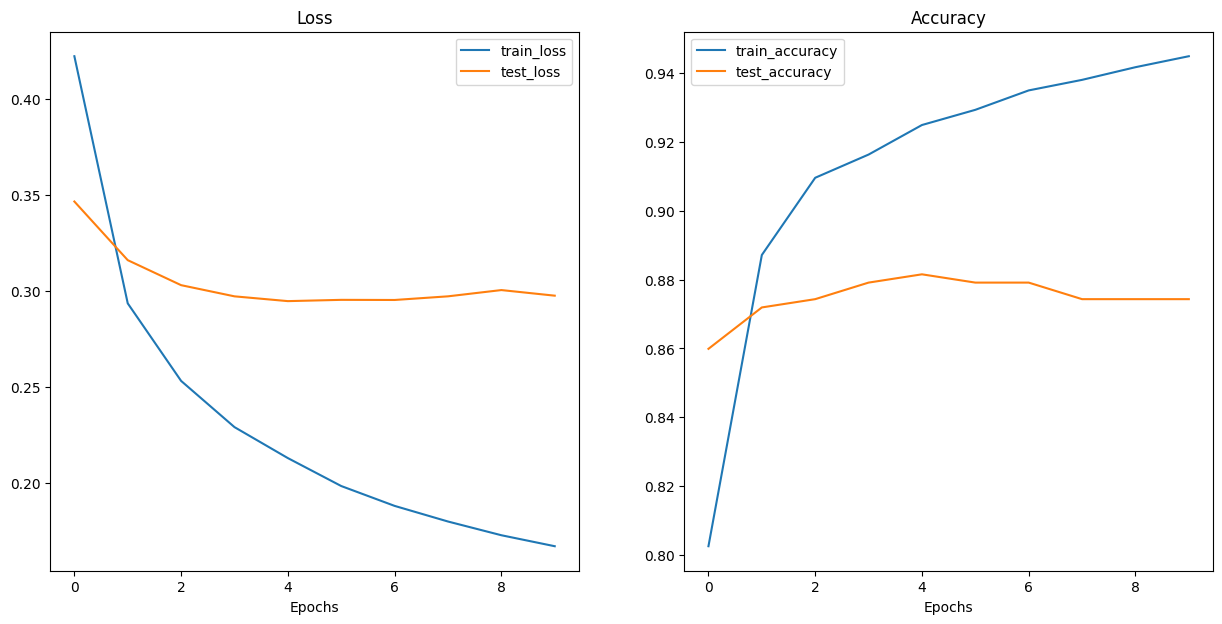

In [ ]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [ ]:
pretrained_vit_weights = torch.load("pretrained_vit_state_dict.pth")

<ipython-input-29-49e29ca4ca20>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_vit = torch.load("pretrained_vit_model_state_dict.pth")
